# DCGAN in MNIST Dataset

## Library Call & Setting

In [1]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

randomness control

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Data Load

In [4]:
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.5))
                    ])

train = datasets.MNIST('./mnist_data/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=True)

## GAN

### Model Definition

hyper-parameter

In [5]:
ngpu = 1 # number of gpu's available
nc = 1   # number of image channels
nz = 100 # input noise dimension
ngf = 64 # number of generator filters
ndf = 64 # number of discriminator filters

epochs = 100
batch_size = 100
data_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

weight initialization

In [6]:
def initialize_weights(model):
    class_names = model.__class__.__name__

    if class_names.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif class_names.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

generator

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            # state size. (nc) x 28 x 28
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

G = Generator(ngpu).to(device)
G.apply(initialize_weights)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

D = Discriminator(ngpu).to(device)
D.apply(initialize_weights)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

loss Function & optimizer

In [9]:
criterion = nn.BCELoss() # BCE_Loss(x, y): -y*log(D(x)) -(1-y)*log(1 - D(x))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=[0.5, 0.999])
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=[0.5, 0.999])

### Training & Visualization

In [10]:
fixed_noise = torch.randn(batch_size, nz, 1, 1).to(device)
real_labels = torch.ones(batch_size).to(device)
fake_labels = torch.zeros(batch_size).to(device)

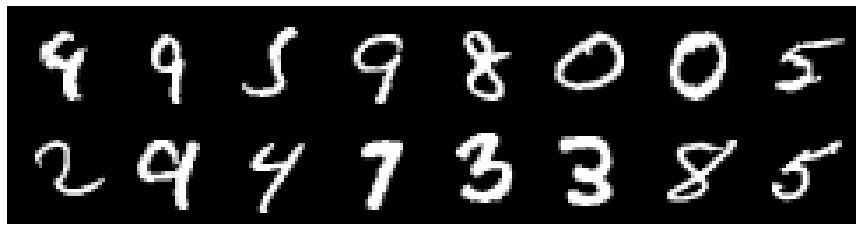

In [11]:
def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    npimg = img.numpy()
    plt.figure(figsize=(20, 4))
    plt.imshow((np.transpose(npimg, (1, 2, 0)) * 255).astype(np.uint8))
    plt.axis('off')
    plt.show()

samples, _ = next(iter(data_loader))
imshow_grid(samples[:16, :, :])


Epoch [1/100]
D_loss: 0.9770, G_loss: 3.1103, D(x): 0.94, D(G(z)): 0.54


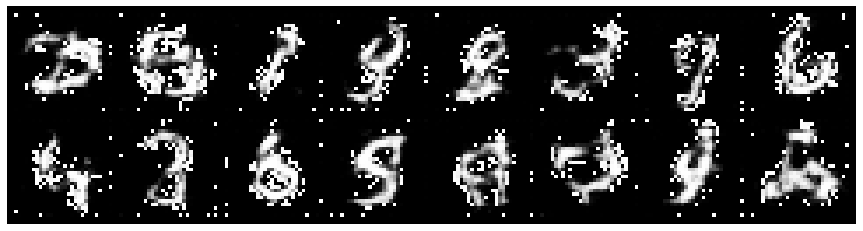


Epoch [2/100]
D_loss: 0.7277, G_loss: 1.7701, D(x): 0.81, D(G(z)): 0.36


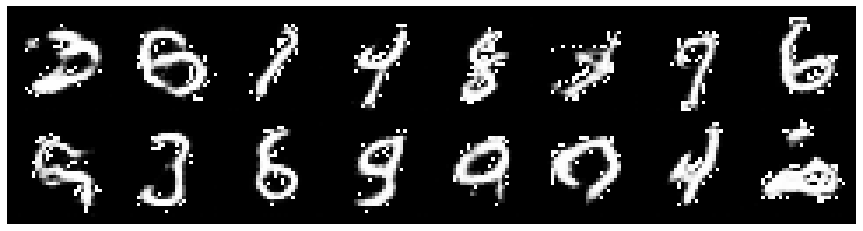


Epoch [3/100]
D_loss: 0.9145, G_loss: 0.9520, D(x): 0.59, D(G(z)): 0.27


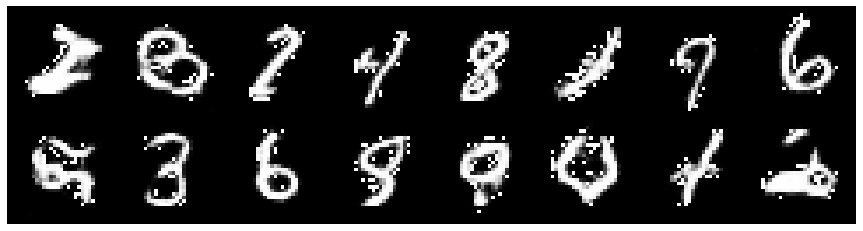


Epoch [4/100]
D_loss: 0.8798, G_loss: 1.1274, D(x): 0.62, D(G(z)): 0.28


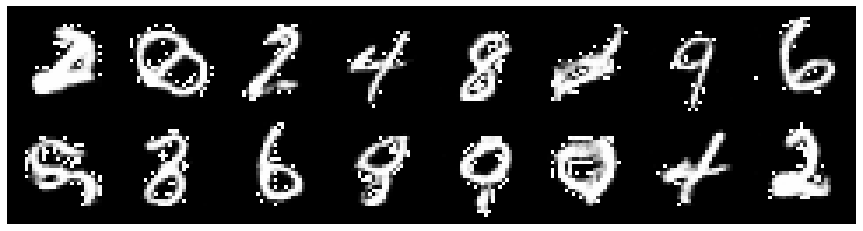


Epoch [5/100]
D_loss: 0.9937, G_loss: 1.0394, D(x): 0.51, D(G(z)): 0.21


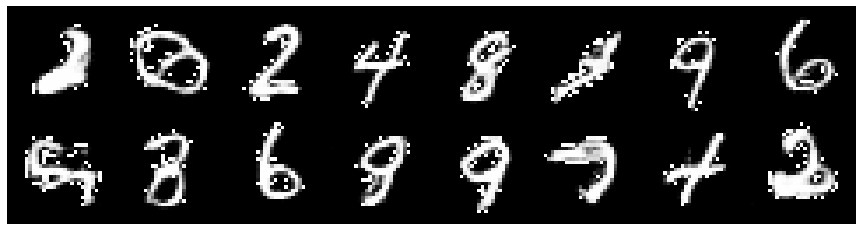


Epoch [6/100]
D_loss: 0.8794, G_loss: 0.7855, D(x): 0.64, D(G(z)): 0.30


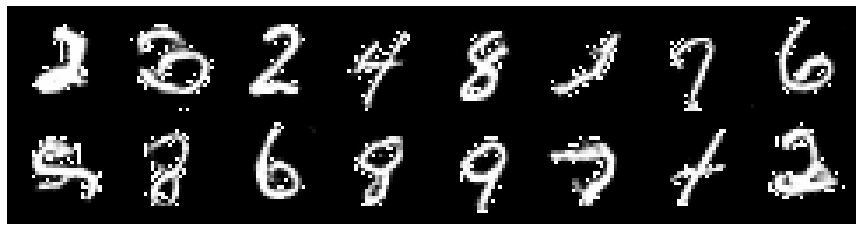


Epoch [7/100]
D_loss: 1.0082, G_loss: 0.9545, D(x): 0.62, D(G(z)): 0.36


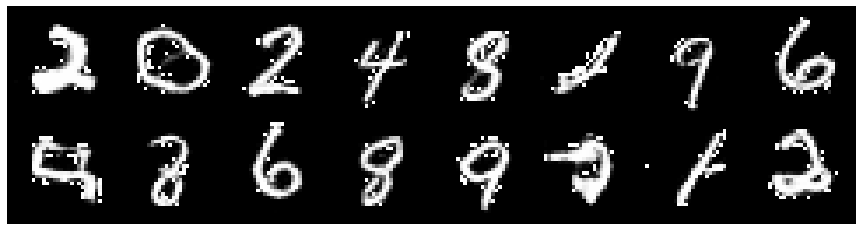


Epoch [8/100]
D_loss: 1.0126, G_loss: 1.5891, D(x): 0.72, D(G(z)): 0.45


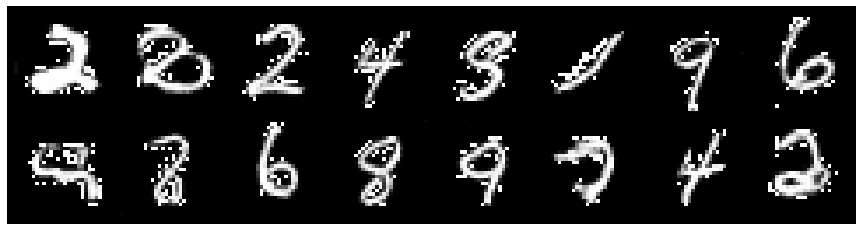


Epoch [9/100]
D_loss: 1.2543, G_loss: 1.1812, D(x): 0.78, D(G(z)): 0.59


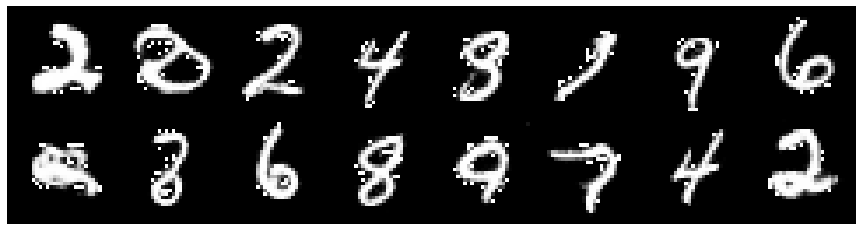


Epoch [10/100]
D_loss: 0.9480, G_loss: 1.1511, D(x): 0.65, D(G(z)): 0.36


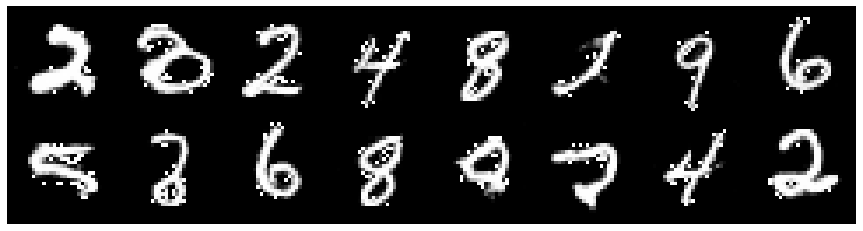


Epoch [11/100]
D_loss: 1.2404, G_loss: 1.9419, D(x): 0.88, D(G(z)): 0.63


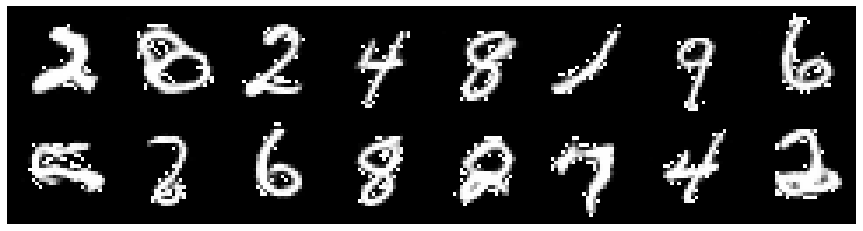


Epoch [12/100]
D_loss: 0.8594, G_loss: 1.5283, D(x): 0.71, D(G(z)): 0.37


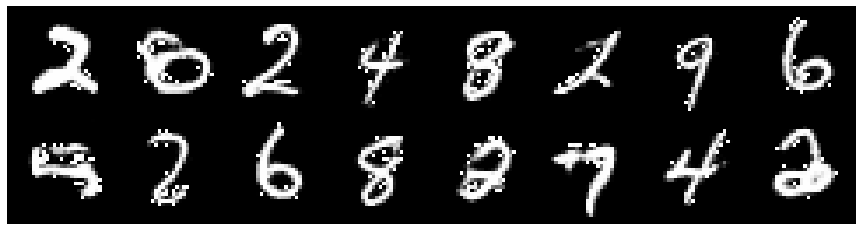


Epoch [13/100]
D_loss: 1.0994, G_loss: 1.5549, D(x): 0.68, D(G(z)): 0.46


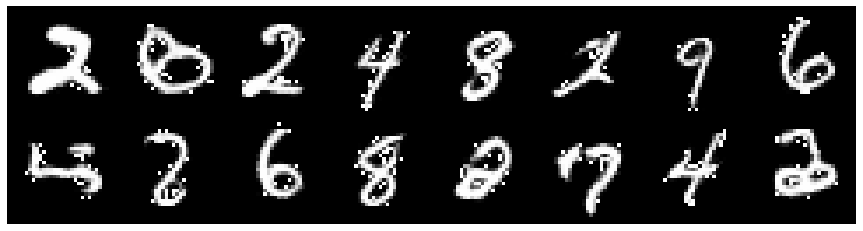


Epoch [14/100]
D_loss: 1.2465, G_loss: 0.8841, D(x): 0.50, D(G(z)): 0.35


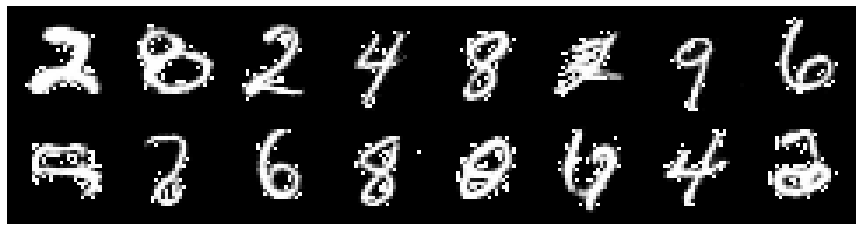


Epoch [15/100]
D_loss: 1.1530, G_loss: 1.1697, D(x): 0.62, D(G(z)): 0.43


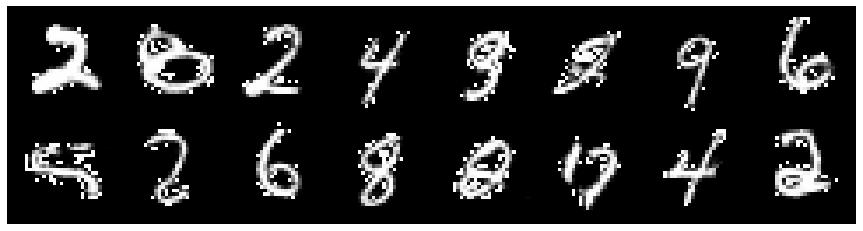


Epoch [16/100]
D_loss: 1.0917, G_loss: 0.9586, D(x): 0.55, D(G(z)): 0.33


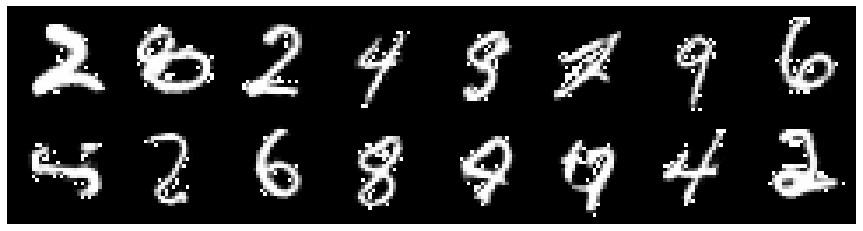


Epoch [17/100]
D_loss: 1.0999, G_loss: 1.2364, D(x): 0.60, D(G(z)): 0.39


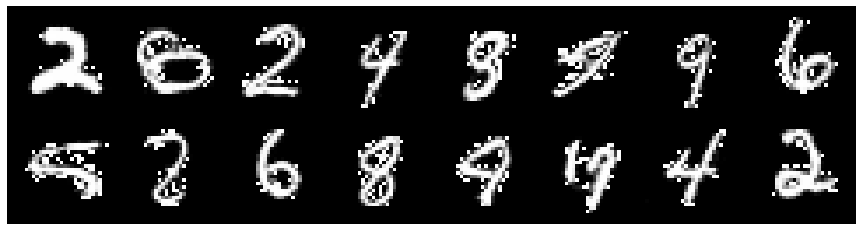


Epoch [18/100]
D_loss: 1.0927, G_loss: 0.6874, D(x): 0.55, D(G(z)): 0.32


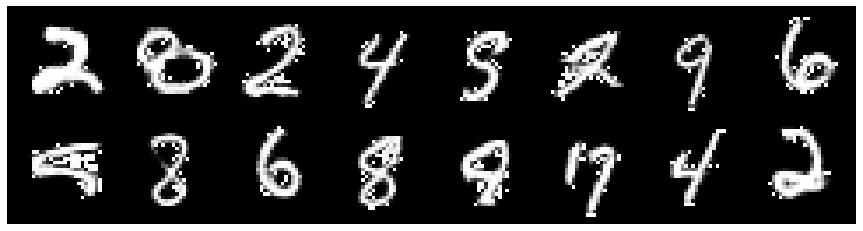


Epoch [19/100]
D_loss: 0.9992, G_loss: 1.6236, D(x): 0.67, D(G(z)): 0.41


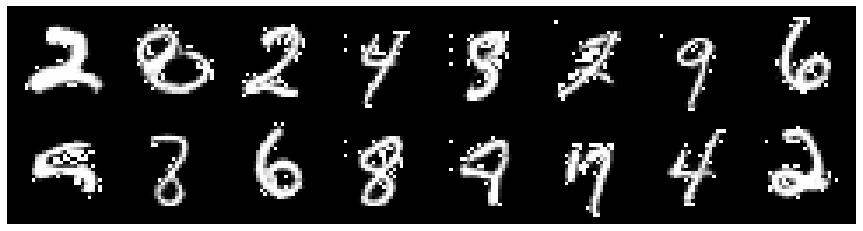


Epoch [20/100]
D_loss: 0.9506, G_loss: 0.9137, D(x): 0.68, D(G(z)): 0.39


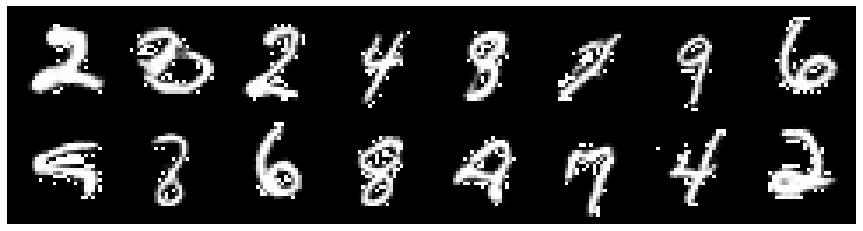


Epoch [21/100]
D_loss: 1.0266, G_loss: 1.3059, D(x): 0.59, D(G(z)): 0.33


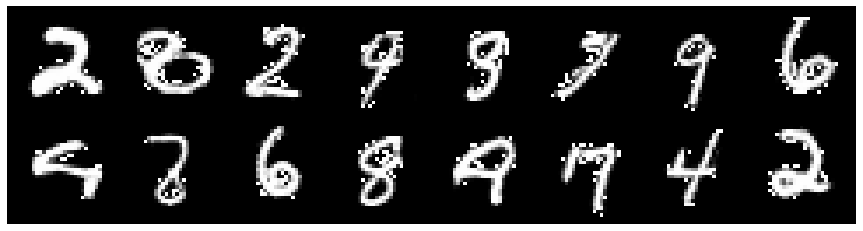


Epoch [22/100]
D_loss: 1.0571, G_loss: 1.0599, D(x): 0.59, D(G(z)): 0.35


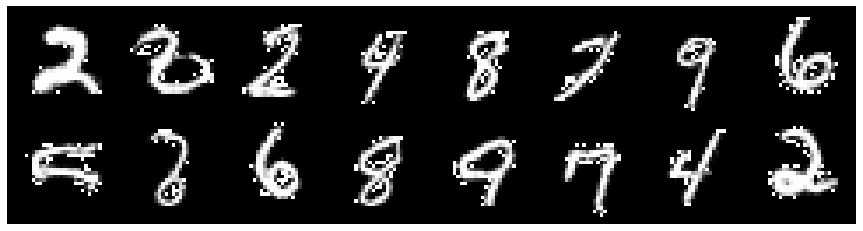


Epoch [23/100]
D_loss: 0.9237, G_loss: 1.0558, D(x): 0.60, D(G(z)): 0.28


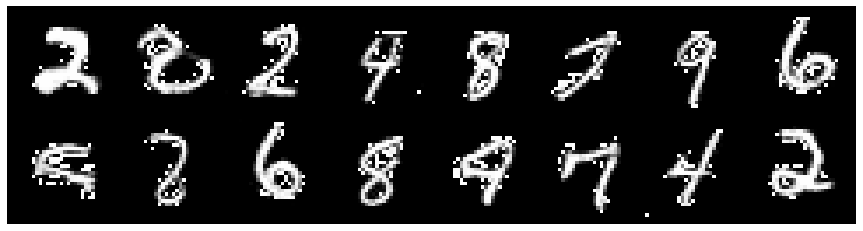


Epoch [24/100]
D_loss: 0.9569, G_loss: 1.3365, D(x): 0.64, D(G(z)): 0.36


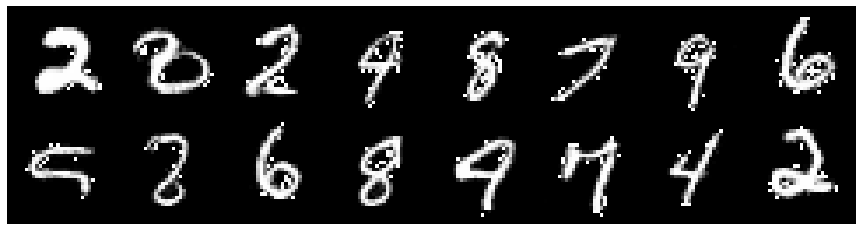


Epoch [25/100]
D_loss: 0.9874, G_loss: 1.2058, D(x): 0.64, D(G(z)): 0.36


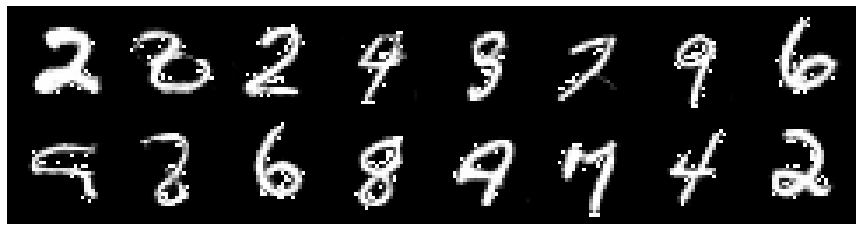


Epoch [26/100]
D_loss: 1.0390, G_loss: 0.9120, D(x): 0.57, D(G(z)): 0.30


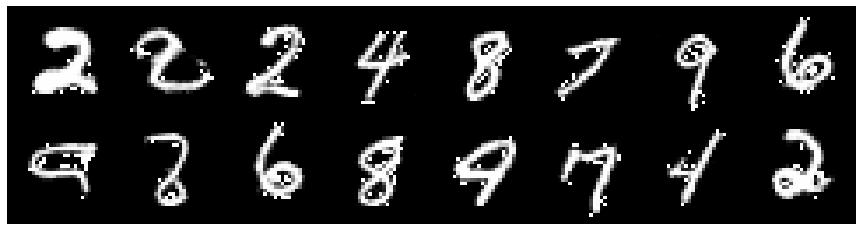


Epoch [27/100]
D_loss: 1.0101, G_loss: 0.8107, D(x): 0.56, D(G(z)): 0.28


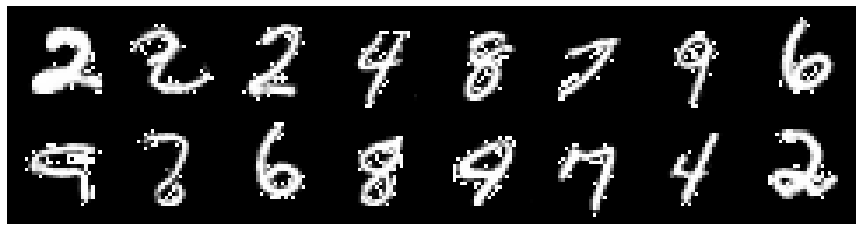


Epoch [28/100]
D_loss: 1.0052, G_loss: 1.3968, D(x): 0.66, D(G(z)): 0.39


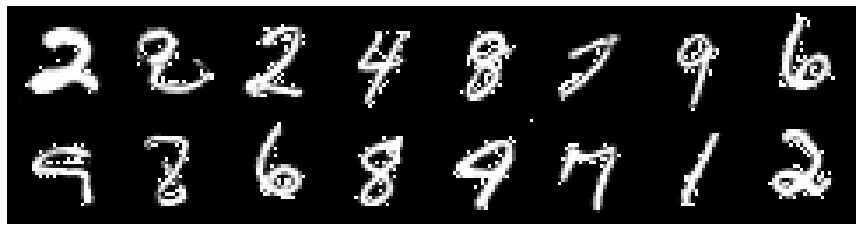


Epoch [29/100]
D_loss: 0.8866, G_loss: 1.1880, D(x): 0.69, D(G(z)): 0.36


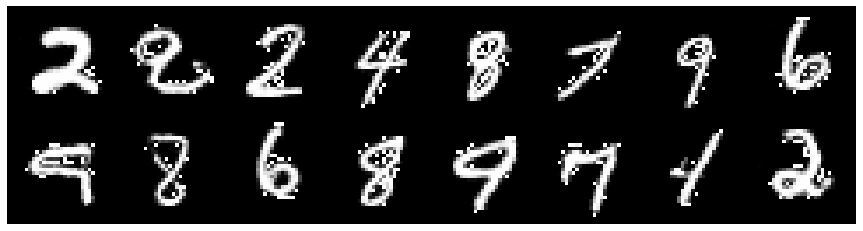


Epoch [30/100]
D_loss: 0.9691, G_loss: 1.3708, D(x): 0.74, D(G(z)): 0.44


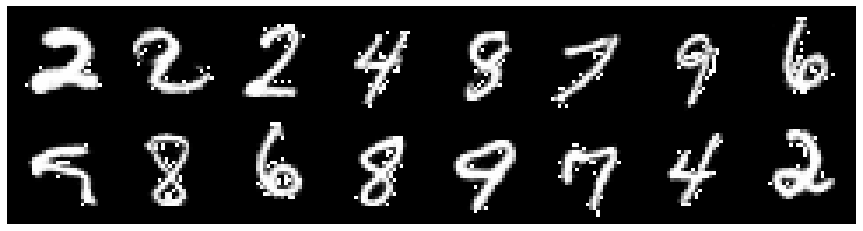


Epoch [31/100]
D_loss: 1.0778, G_loss: 1.6483, D(x): 0.77, D(G(z)): 0.51


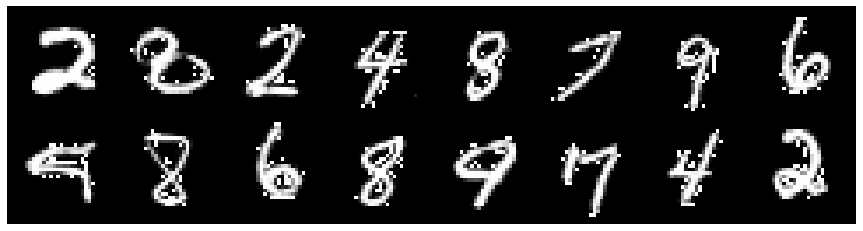


Epoch [32/100]
D_loss: 0.9127, G_loss: 1.6021, D(x): 0.72, D(G(z)): 0.38


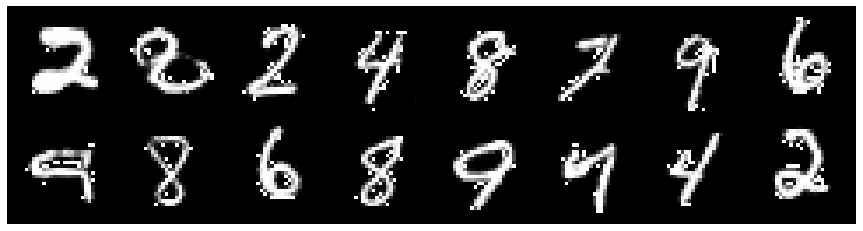


Epoch [33/100]
D_loss: 1.0245, G_loss: 1.5552, D(x): 0.70, D(G(z)): 0.43


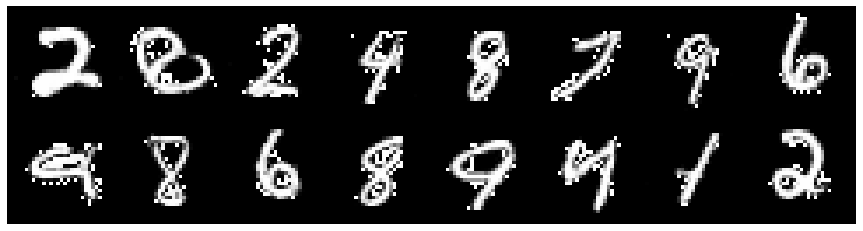


Epoch [34/100]
D_loss: 1.0577, G_loss: 1.8870, D(x): 0.78, D(G(z)): 0.50


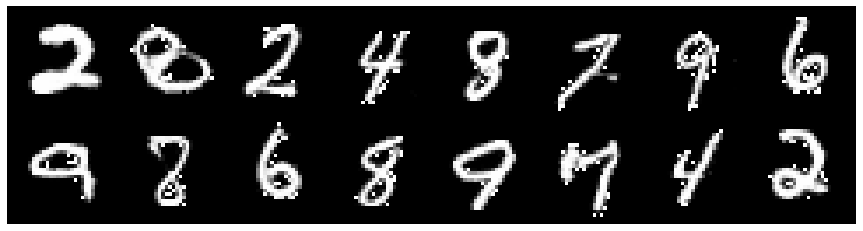


Epoch [35/100]
D_loss: 0.9983, G_loss: 1.4423, D(x): 0.56, D(G(z)): 0.27


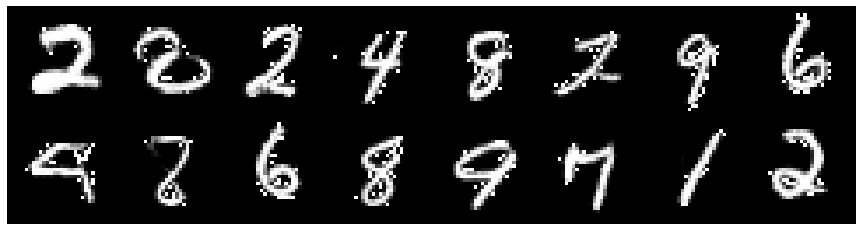


Epoch [36/100]
D_loss: 0.9379, G_loss: 2.1460, D(x): 0.73, D(G(z)): 0.41


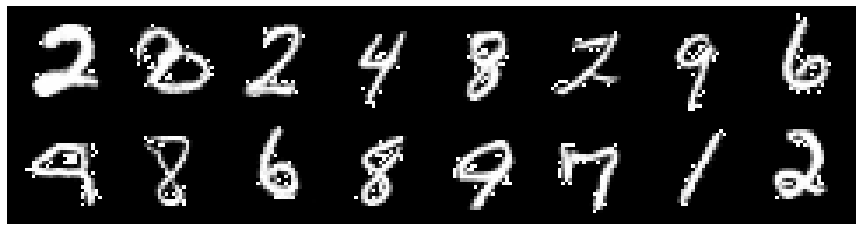


Epoch [37/100]
D_loss: 1.0557, G_loss: 1.7719, D(x): 0.68, D(G(z)): 0.40


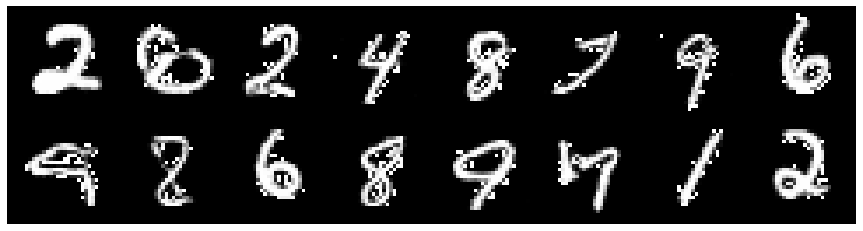


Epoch [38/100]
D_loss: 0.8383, G_loss: 1.3417, D(x): 0.69, D(G(z)): 0.32


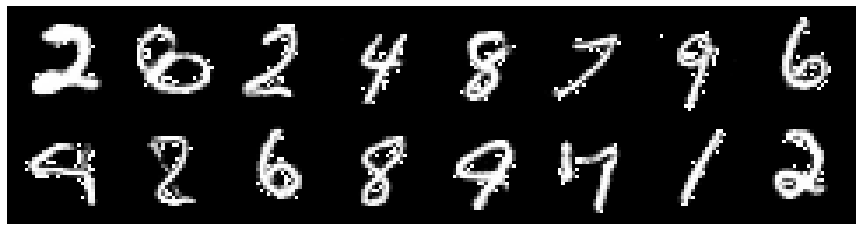


Epoch [39/100]
D_loss: 0.9840, G_loss: 1.1301, D(x): 0.66, D(G(z)): 0.37


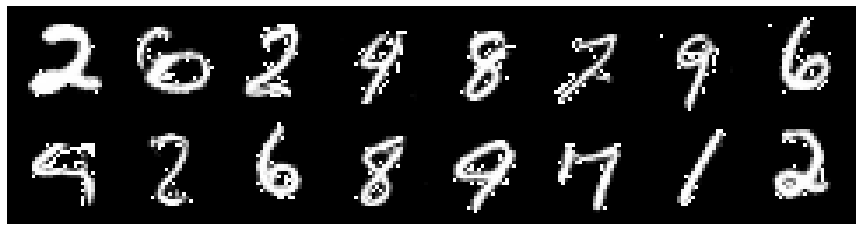


Epoch [40/100]
D_loss: 0.8920, G_loss: 1.4225, D(x): 0.66, D(G(z)): 0.33


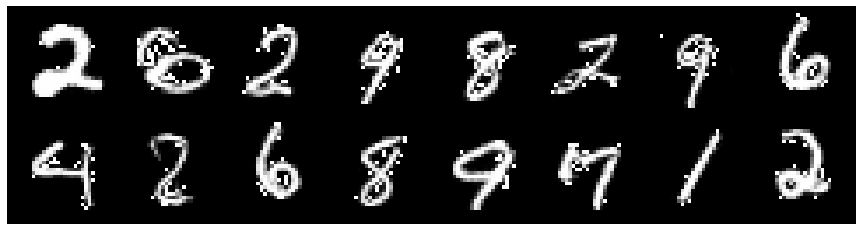


Epoch [41/100]
D_loss: 0.7670, G_loss: 1.4625, D(x): 0.72, D(G(z)): 0.30


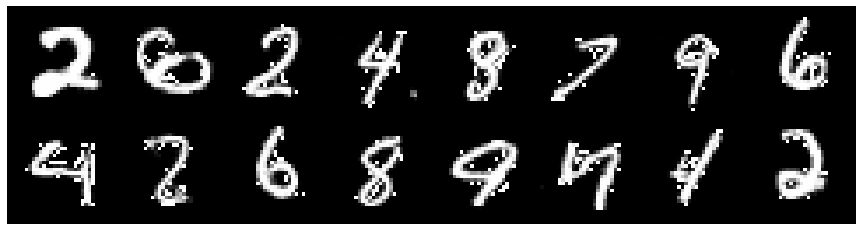


Epoch [42/100]
D_loss: 0.8886, G_loss: 1.7656, D(x): 0.75, D(G(z)): 0.39


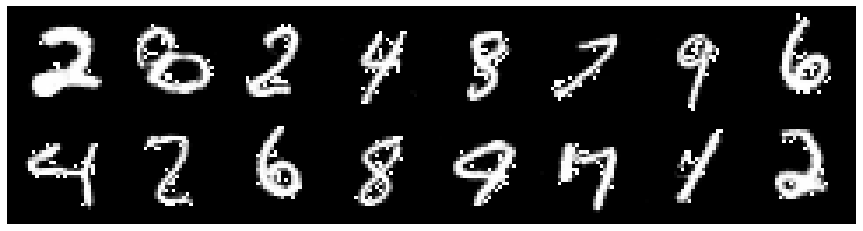


Epoch [43/100]
D_loss: 1.0257, G_loss: 1.7270, D(x): 0.77, D(G(z)): 0.46


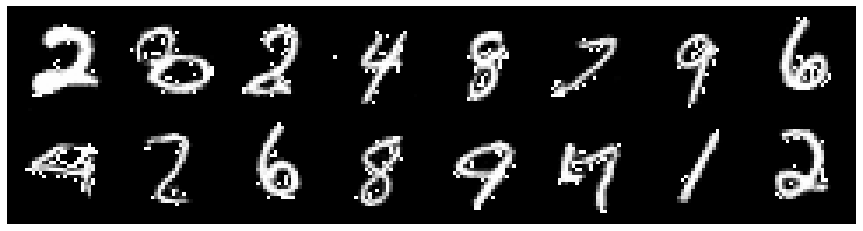


Epoch [44/100]
D_loss: 0.9508, G_loss: 1.3141, D(x): 0.57, D(G(z)): 0.25


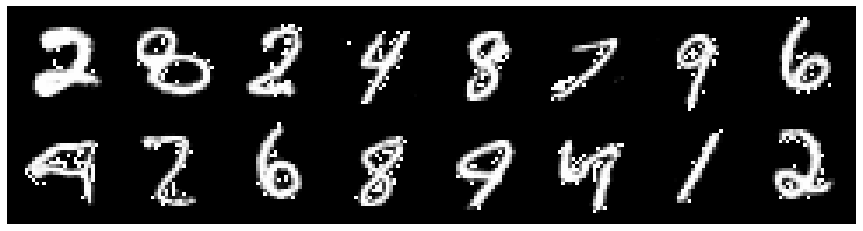


Epoch [45/100]
D_loss: 0.8391, G_loss: 1.4013, D(x): 0.67, D(G(z)): 0.29


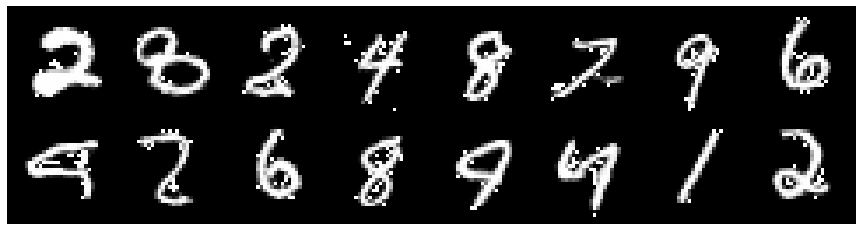


Epoch [46/100]
D_loss: 0.9316, G_loss: 1.5703, D(x): 0.76, D(G(z)): 0.41


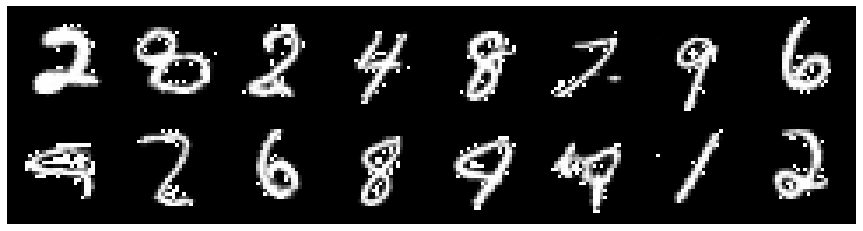


Epoch [47/100]
D_loss: 0.6881, G_loss: 1.5954, D(x): 0.75, D(G(z)): 0.26


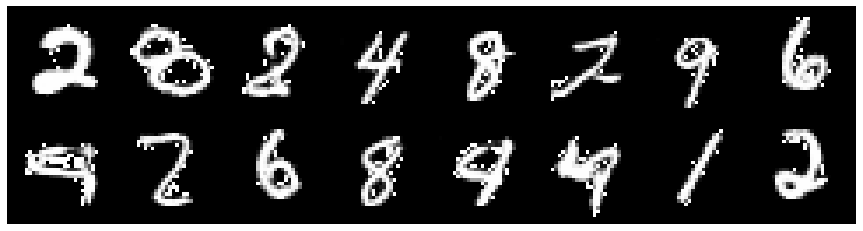


Epoch [48/100]
D_loss: 0.9780, G_loss: 1.5368, D(x): 0.60, D(G(z)): 0.29


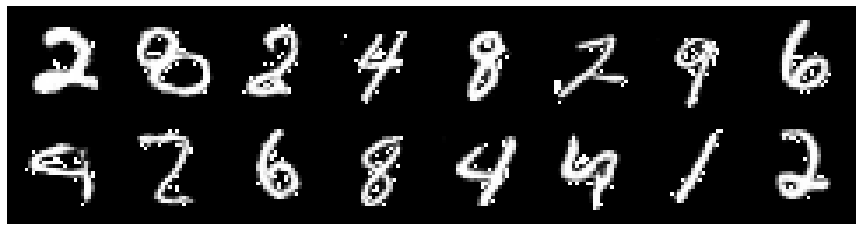


Epoch [49/100]
D_loss: 0.9085, G_loss: 1.5741, D(x): 0.73, D(G(z)): 0.37


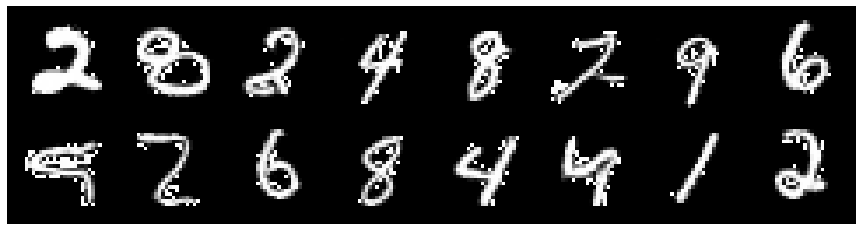


Epoch [50/100]
D_loss: 0.7704, G_loss: 1.2444, D(x): 0.61, D(G(z)): 0.16


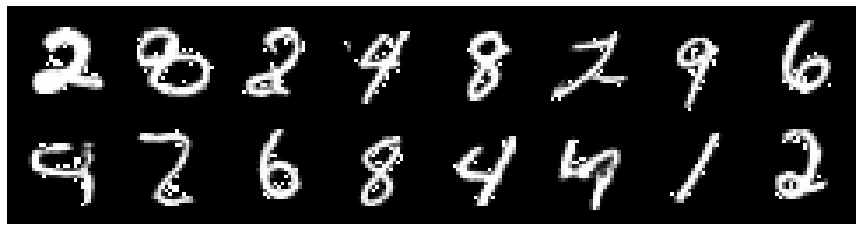


Epoch [51/100]
D_loss: 0.7094, G_loss: 1.2503, D(x): 0.66, D(G(z)): 0.20


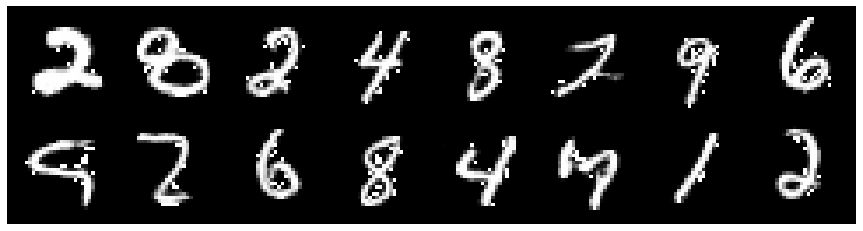


Epoch [52/100]
D_loss: 0.7935, G_loss: 1.6658, D(x): 0.72, D(G(z)): 0.31


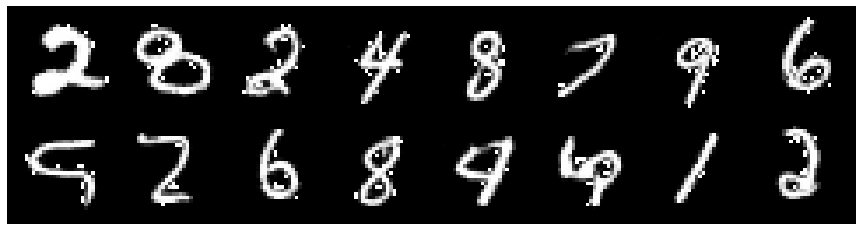


Epoch [53/100]
D_loss: 0.9041, G_loss: 1.3731, D(x): 0.69, D(G(z)): 0.33


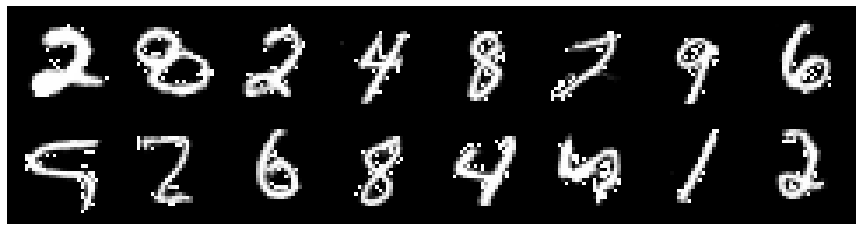


Epoch [54/100]
D_loss: 0.8706, G_loss: 2.0789, D(x): 0.77, D(G(z)): 0.38


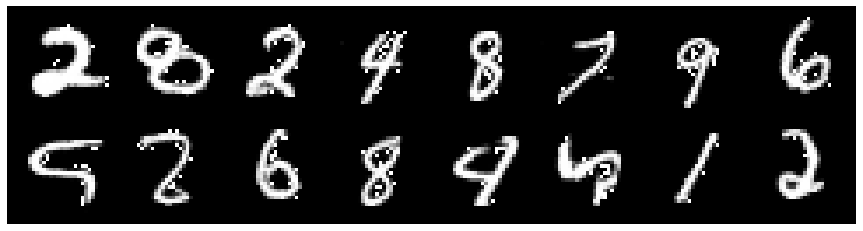


Epoch [55/100]
D_loss: 0.8192, G_loss: 1.9700, D(x): 0.80, D(G(z)): 0.39


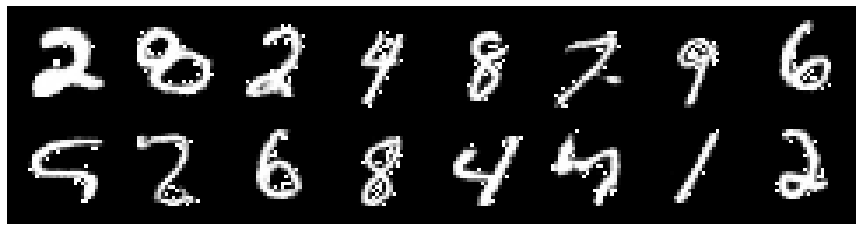


Epoch [56/100]
D_loss: 0.7040, G_loss: 2.7382, D(x): 0.82, D(G(z)): 0.34


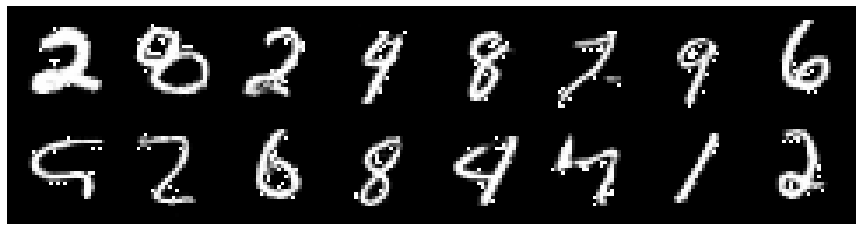


Epoch [57/100]
D_loss: 0.8263, G_loss: 2.0404, D(x): 0.71, D(G(z)): 0.31


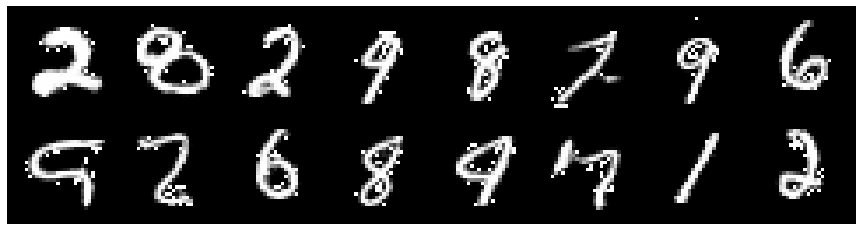


Epoch [58/100]
D_loss: 0.6363, G_loss: 1.8384, D(x): 0.77, D(G(z)): 0.26


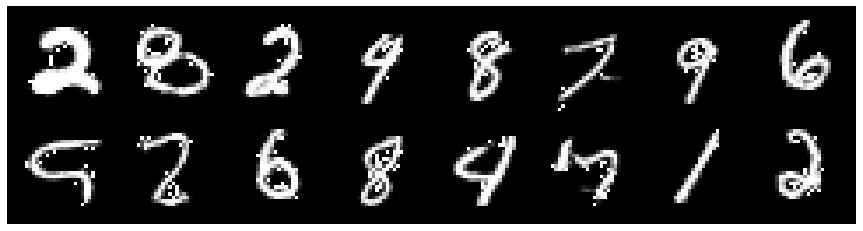


Epoch [59/100]
D_loss: 0.6506, G_loss: 2.0004, D(x): 0.77, D(G(z)): 0.26


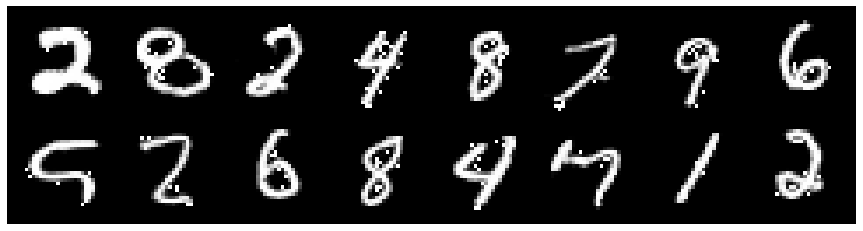


Epoch [60/100]
D_loss: 0.7866, G_loss: 1.1476, D(x): 0.59, D(G(z)): 0.16


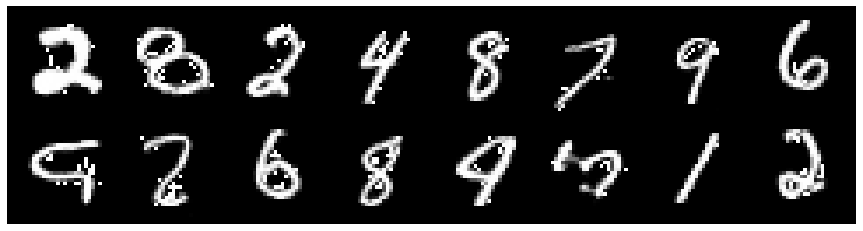


Epoch [61/100]
D_loss: 0.7627, G_loss: 2.4662, D(x): 0.82, D(G(z)): 0.34


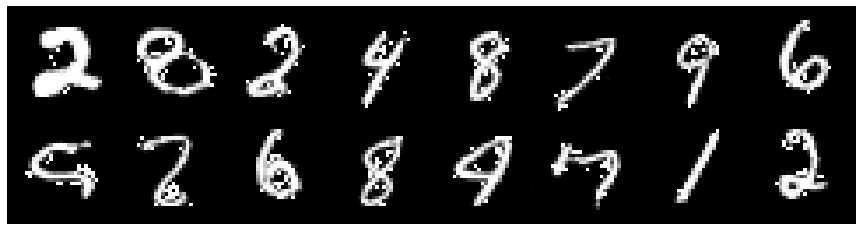


Epoch [62/100]
D_loss: 0.9009, G_loss: 1.5172, D(x): 0.54, D(G(z)): 0.13


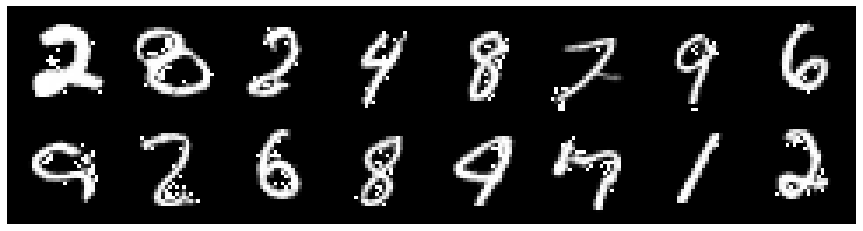


Epoch [63/100]
D_loss: 0.6614, G_loss: 2.1753, D(x): 0.82, D(G(z)): 0.32


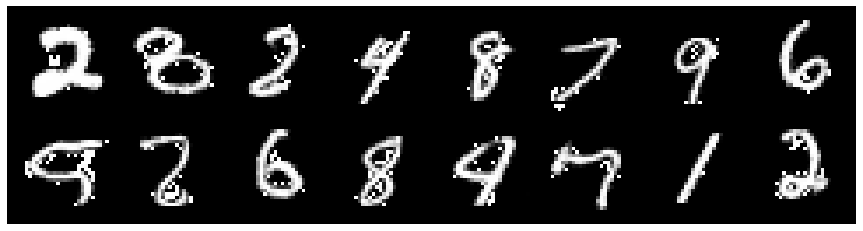


Epoch [64/100]
D_loss: 0.7913, G_loss: 1.9535, D(x): 0.64, D(G(z)): 0.20


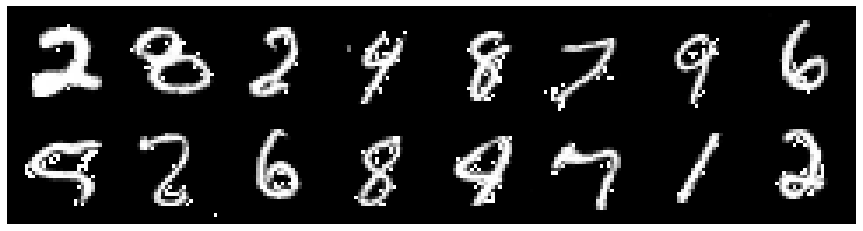


Epoch [65/100]
D_loss: 0.6572, G_loss: 1.9474, D(x): 0.82, D(G(z)): 0.29


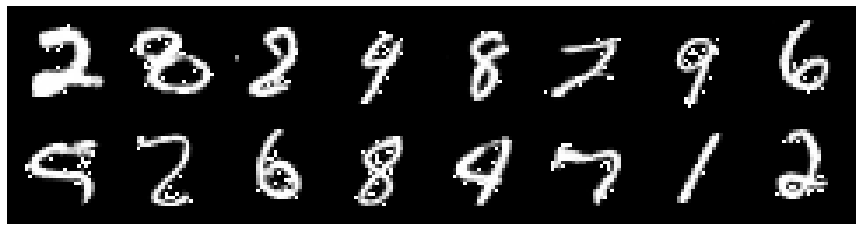


Epoch [66/100]
D_loss: 0.5382, G_loss: 2.3066, D(x): 0.76, D(G(z)): 0.18


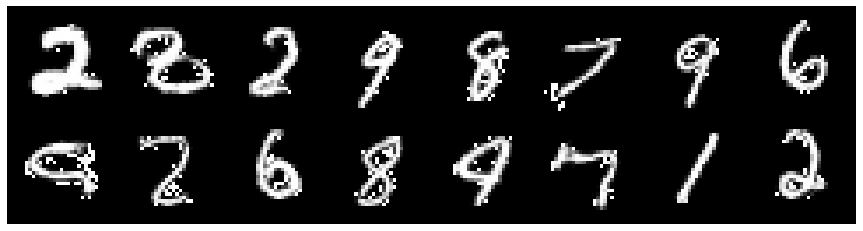


Epoch [67/100]
D_loss: 0.8554, G_loss: 1.7756, D(x): 0.61, D(G(z)): 0.19


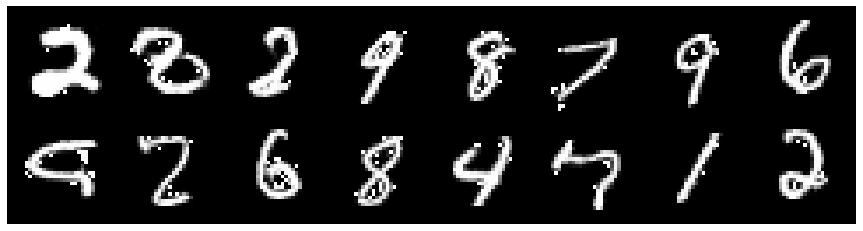


Epoch [68/100]
D_loss: 0.5265, G_loss: 1.5014, D(x): 0.78, D(G(z)): 0.19


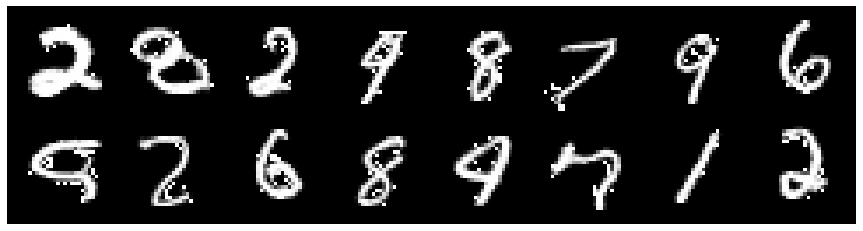


Epoch [69/100]
D_loss: 0.8017, G_loss: 2.6000, D(x): 0.81, D(G(z)): 0.37


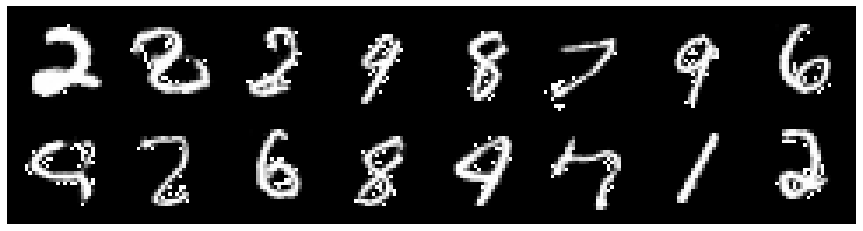


Epoch [70/100]
D_loss: 0.5529, G_loss: 1.5377, D(x): 0.76, D(G(z)): 0.18


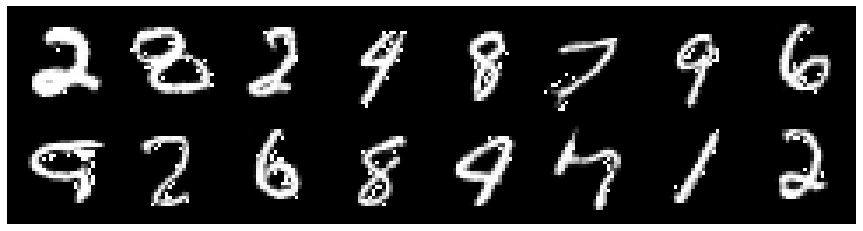


Epoch [71/100]
D_loss: 0.6330, G_loss: 3.0823, D(x): 0.91, D(G(z)): 0.35


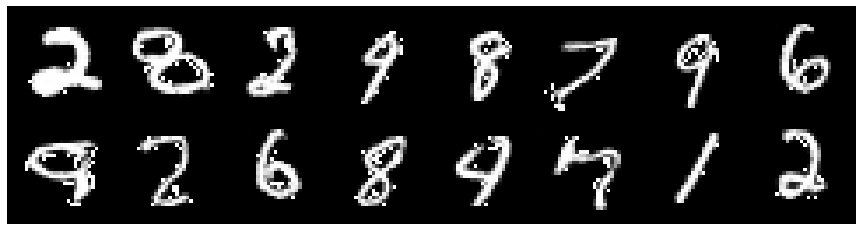


Epoch [72/100]
D_loss: 0.5428, G_loss: 1.6907, D(x): 0.85, D(G(z)): 0.25


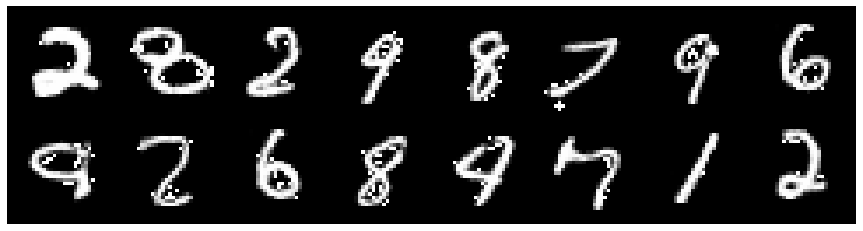


Epoch [73/100]
D_loss: 0.5346, G_loss: 2.1065, D(x): 0.85, D(G(z)): 0.26


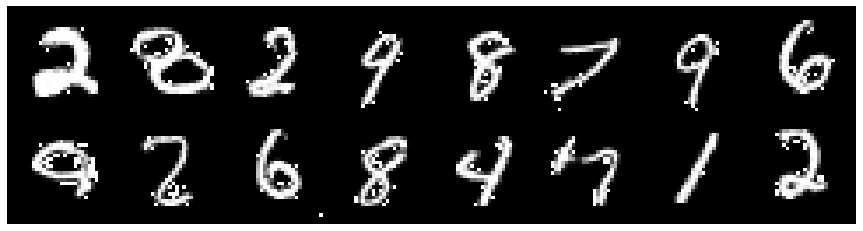


Epoch [74/100]
D_loss: 0.4493, G_loss: 2.0566, D(x): 0.89, D(G(z)): 0.24


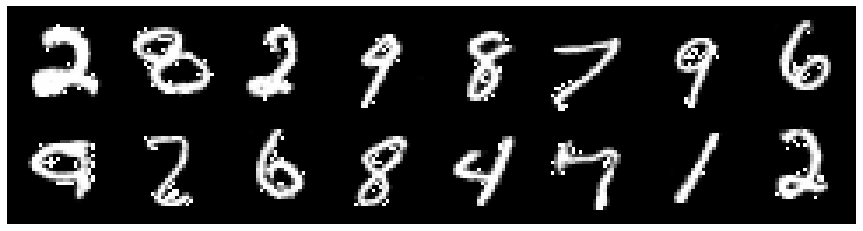


Epoch [75/100]
D_loss: 0.4674, G_loss: 3.1227, D(x): 0.82, D(G(z)): 0.19


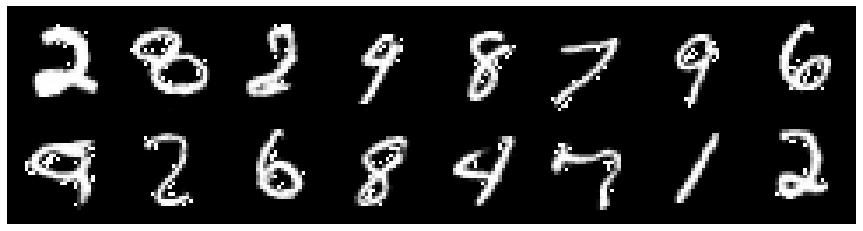


Epoch [76/100]
D_loss: 0.6838, G_loss: 2.0089, D(x): 0.71, D(G(z)): 0.21


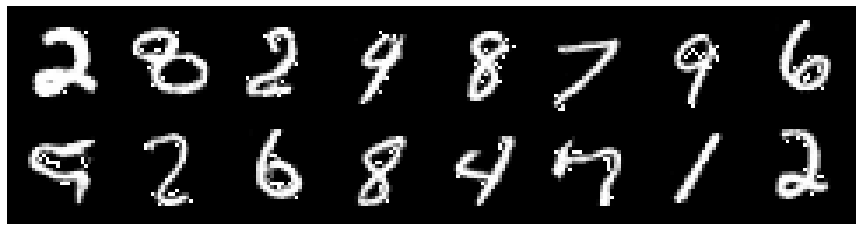


Epoch [77/100]
D_loss: 0.4955, G_loss: 1.6229, D(x): 0.77, D(G(z)): 0.16


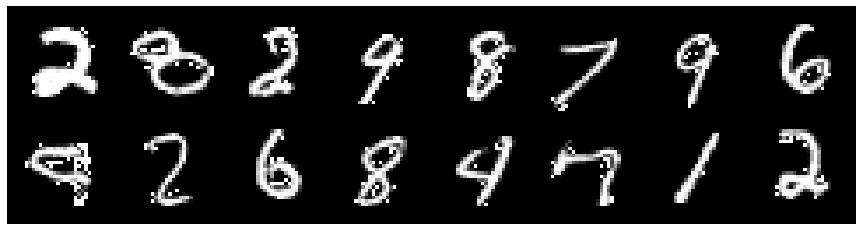


Epoch [78/100]
D_loss: 0.5802, G_loss: 2.4188, D(x): 0.80, D(G(z)): 0.25


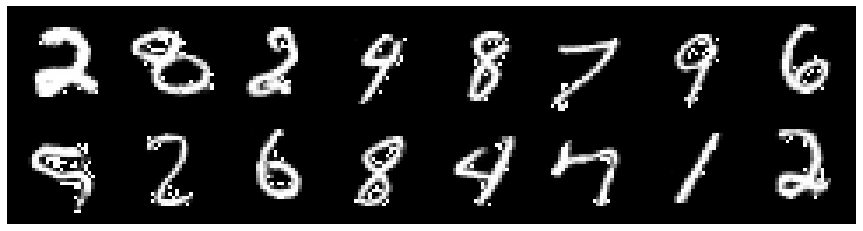


Epoch [79/100]
D_loss: 0.9043, G_loss: 1.8813, D(x): 0.50, D(G(z)): 0.04


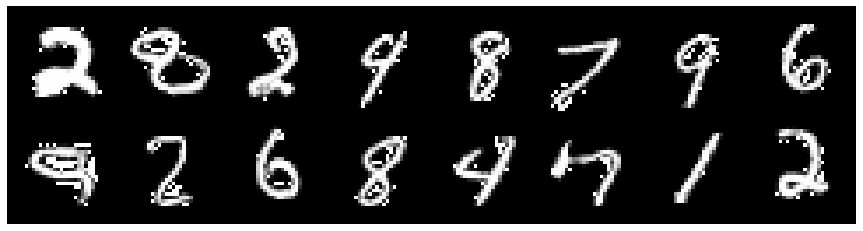


Epoch [80/100]
D_loss: 0.6087, G_loss: 2.5486, D(x): 0.84, D(G(z)): 0.31


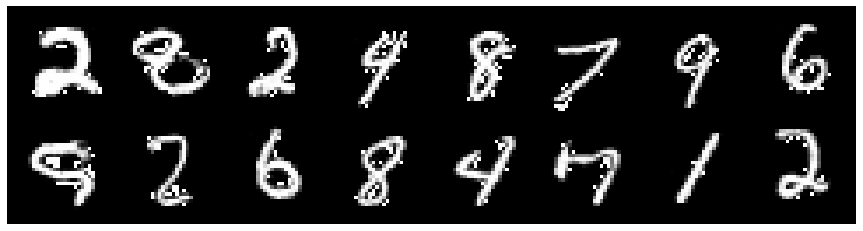


Epoch [81/100]
D_loss: 0.6172, G_loss: 3.0202, D(x): 0.87, D(G(z)): 0.31


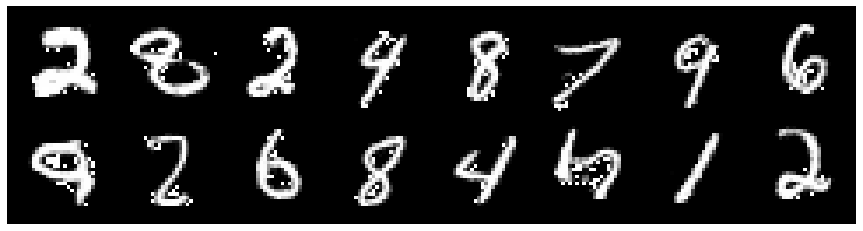


Epoch [82/100]
D_loss: 0.5722, G_loss: 1.8670, D(x): 0.86, D(G(z)): 0.27


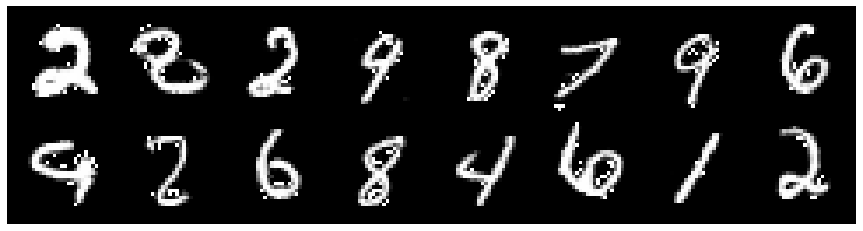


Epoch [83/100]
D_loss: 0.4513, G_loss: 2.8469, D(x): 0.89, D(G(z)): 0.23


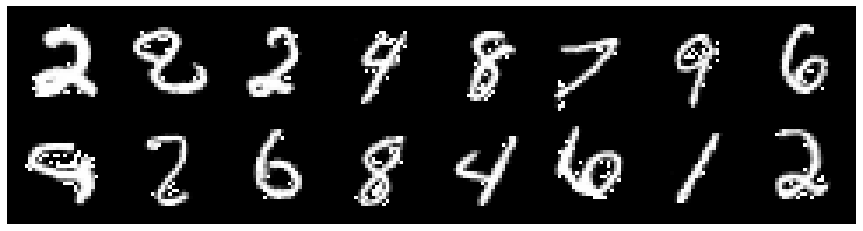


Epoch [84/100]
D_loss: 0.6452, G_loss: 1.5291, D(x): 0.69, D(G(z)): 0.14


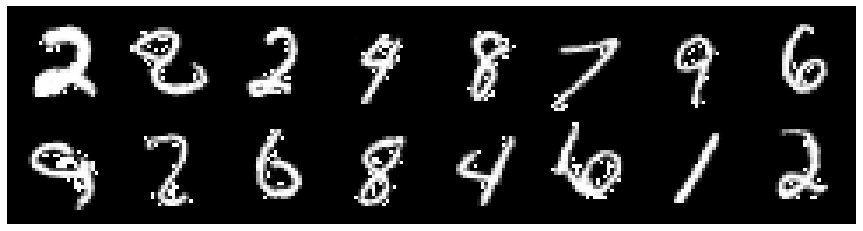


Epoch [85/100]
D_loss: 0.5414, G_loss: 2.7203, D(x): 0.91, D(G(z)): 0.26


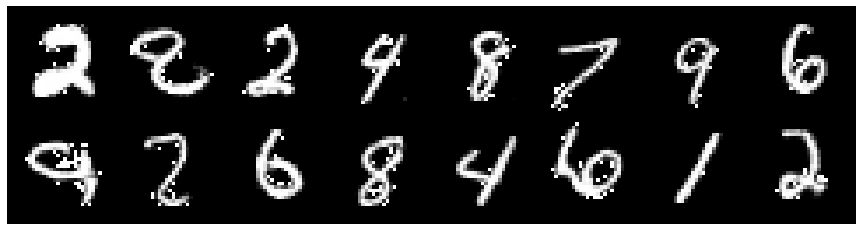


Epoch [86/100]
D_loss: 0.4602, G_loss: 2.5927, D(x): 0.87, D(G(z)): 0.22


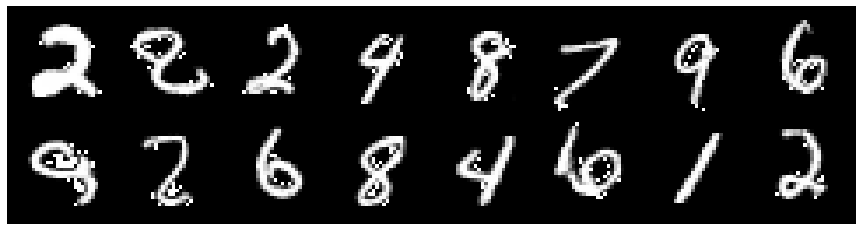


Epoch [87/100]
D_loss: 0.5082, G_loss: 2.2738, D(x): 0.93, D(G(z)): 0.28


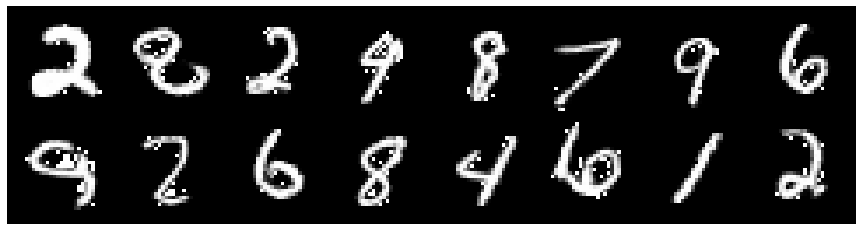


Epoch [88/100]
D_loss: 0.3260, G_loss: 2.2998, D(x): 0.88, D(G(z)): 0.14


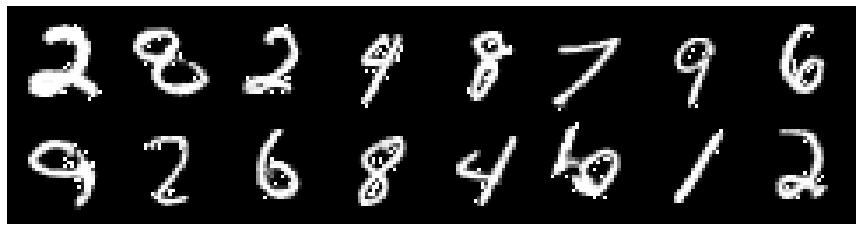


Epoch [89/100]
D_loss: 0.4124, G_loss: 2.8641, D(x): 0.78, D(G(z)): 0.10


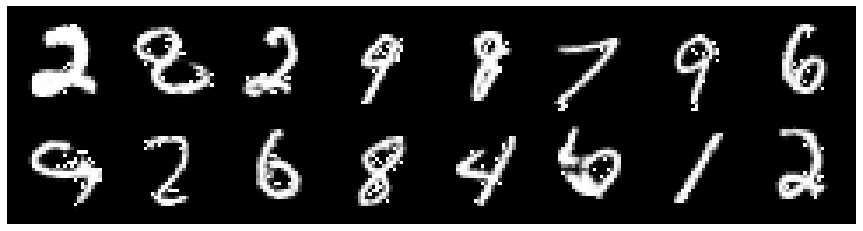


Epoch [90/100]
D_loss: 0.5854, G_loss: 1.5868, D(x): 0.71, D(G(z)): 0.14


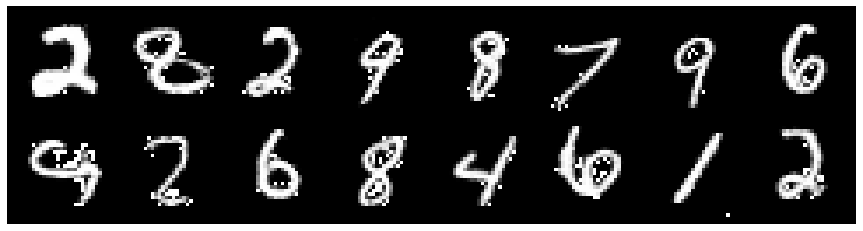


Epoch [91/100]
D_loss: 0.3847, G_loss: 2.0780, D(x): 0.82, D(G(z)): 0.12


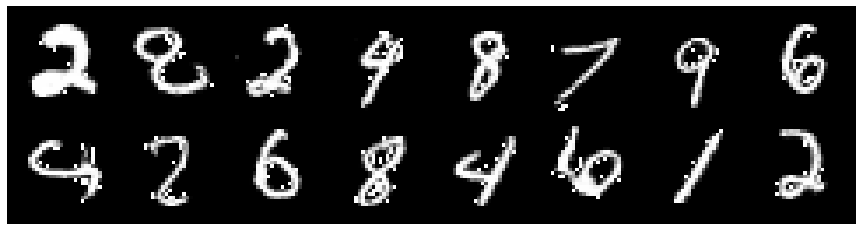


Epoch [92/100]
D_loss: 0.4847, G_loss: 2.4102, D(x): 0.76, D(G(z)): 0.14


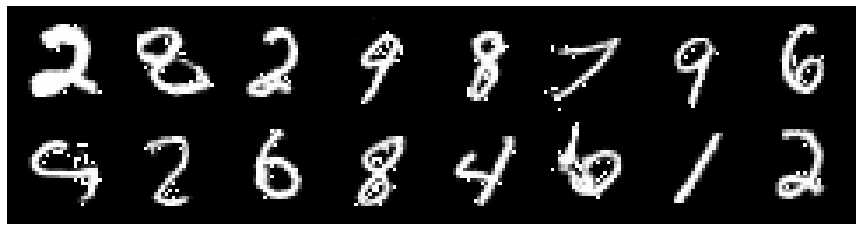


Epoch [93/100]
D_loss: 0.3961, G_loss: 2.6836, D(x): 0.88, D(G(z)): 0.19


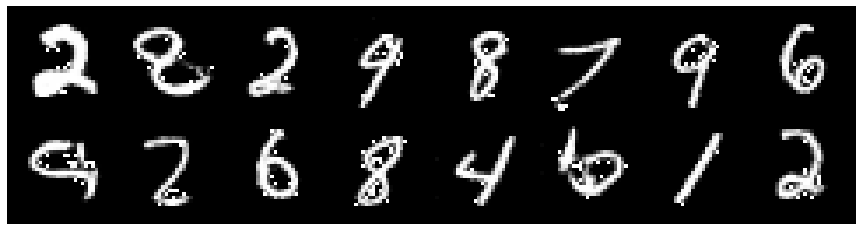


Epoch [94/100]
D_loss: 0.6195, G_loss: 2.2054, D(x): 0.70, D(G(z)): 0.14


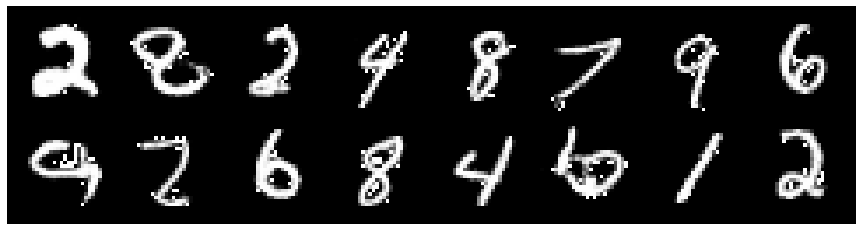


Epoch [95/100]
D_loss: 0.3242, G_loss: 2.0687, D(x): 0.83, D(G(z)): 0.10


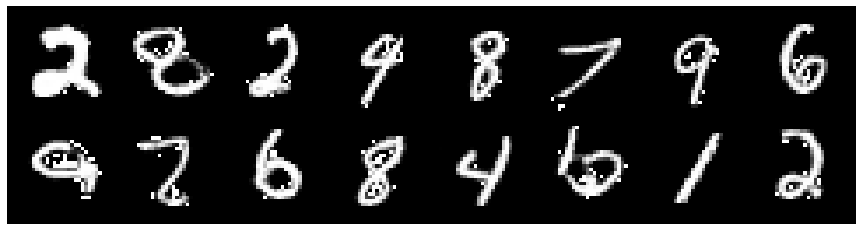


Epoch [96/100]
D_loss: 0.3768, G_loss: 2.8298, D(x): 0.88, D(G(z)): 0.17


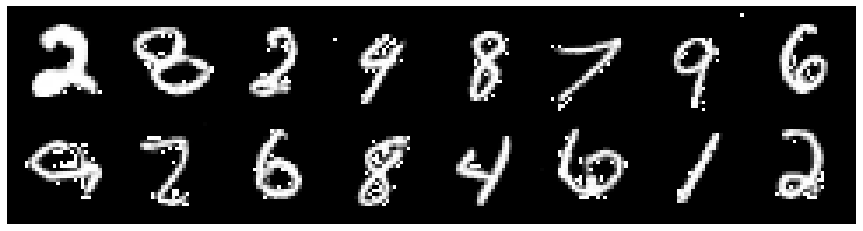


Epoch [97/100]
D_loss: 0.5067, G_loss: 3.6593, D(x): 0.84, D(G(z)): 0.22


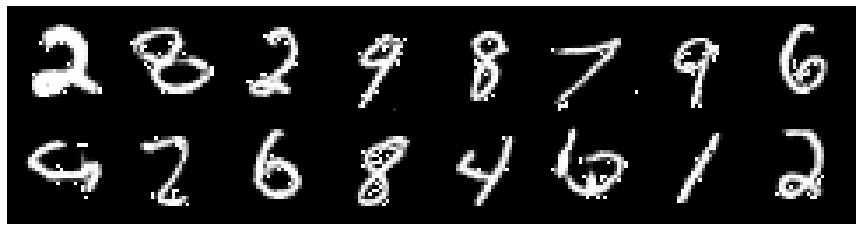


Epoch [98/100]
D_loss: 0.7766, G_loss: 1.5106, D(x): 0.60, D(G(z)): 0.12


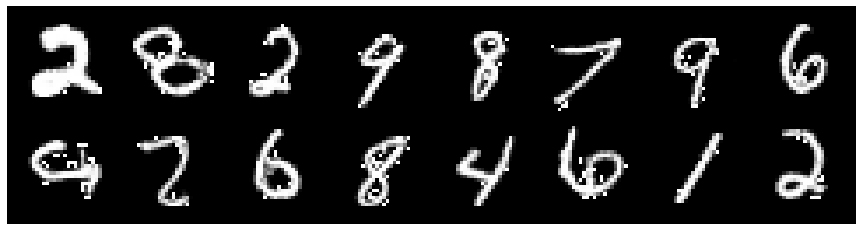


Epoch [99/100]
D_loss: 0.5312, G_loss: 1.8393, D(x): 0.74, D(G(z)): 0.15


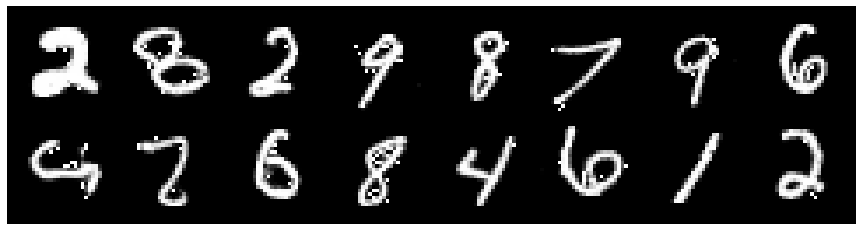


Epoch [100/100]
D_loss: 0.5360, G_loss: 2.0737, D(x): 0.75, D(G(z)): 0.15


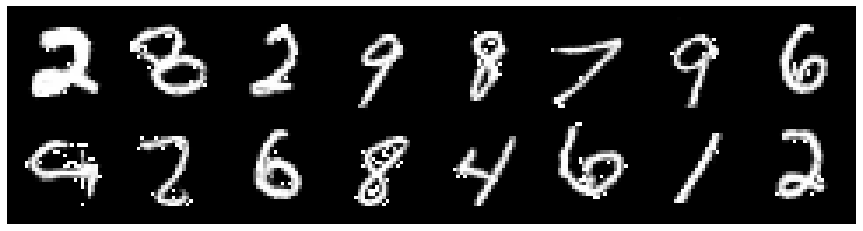

In [12]:
for epoch in range(1, epochs+1):
    for images, labels in data_loader:
        images = images.to(device)

        # Discriminator
        outputs = D(images)
        D_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, nz, 1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        D_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        D_loss = D_loss_real + D_loss_fake

        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        # Generator
        z = torch.randn(batch_size, nz, 1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        G_loss = criterion(outputs, real_labels)

        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

    print(f"\nEpoch [{epoch}/{epochs}]\nD_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}")
    fake = G(fixed_noise)
    imshow_grid(fake[:16, :, :])

### Result

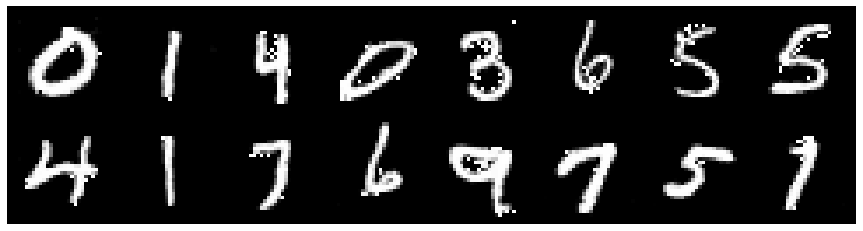

In [13]:
new_noise = torch.randn(16, nz, 1, 1, device=device)
fake = G(new_noise)
imshow_grid(fake)

### Model Weight Save

In [14]:
torch.save(D.state_dict(), f'D_epoch_{epoch}.pth')
torch.save(G.state_dict(), f'G_epoch_{epoch}.pth')